# WFPT segment Zernike modes
This notebooks shows how to compute the best fit of segment Zernike modes (in the exit pupil) as linear combination of PTT and DM commands. The goal is to produce a best fit that minimizes the spillage of wavefront error **outside** the particular segment pupil that would otherwise create a cross-talk between adjacent segments.

Developed by: Fernando Quiros-Pacheco

Last update: 05/08/2023

In [1]:
from ceo import constants, StopWatch
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/CEO/python/ceo/zemax


In [2]:
from ceo import wfpt_visulib, wfpt_zernike_modes_creation

## Initialize Zernike modes creation tool

In [3]:
M2_baffle_diam=0.0 # 3.6  # size of M2 baffle
project_truss_onaxis=False # simulate truss shadows over central segment
path = 'SH'
zerntool = wfpt_zernike_modes_creation(M2_baffle_diam=M2_baffle_diam, 
                                project_truss_onaxis=project_truss_onaxis, path=path)
nPx = zerntool.src._nPx

ZemaxModel does not have attribute IWDP
ZemaxModel does not have attribute EERA
SH48 pixel scale: 0.321 arcsec
ZemaxModel does not have attribute IWDP
ZemaxModel does not have attribute EERA
SH source FWHM: 0.642 arcsec
Total SH valid sub-apertures: 1281
SH48 calibration completed.
DFS calibration completed.


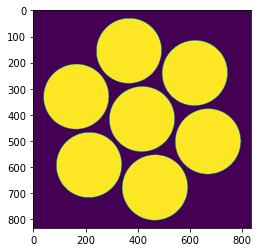

In [4]:
plt.imshow(zerntool.GMTmask)

## Theoretical segment Zernike modes

There are about 16 valid DM actuators across the GMT pupil, so ~5 per segment. Therefore, we limit the number of Zernike modes to radial order <=5. Preliminary fittings show that we can properly fit up to ~15 zernike modes (i.e radial order 4).

In [5]:
%%time
radord = 4
CS_rotation = True
zerntool.get_zernikes(zernikes_radial_order=radord, CS_rotation=CS_rotation)

Zernike Influence Function Matrix:
(693889, 15, 7)
--> Theoretical Zernikes computed successfully.
CPU times: user 54.2 s, sys: 4.18 s, total: 58.4 s
Wall time: 46 s


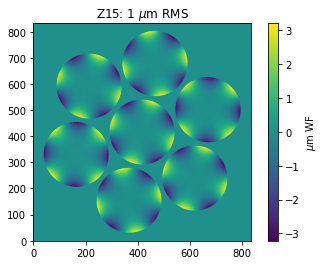

In [6]:
#----- Show a segment Zernike just for fun on every segment.
this_mode = 14
phtemp = np.zeros((nPx,nPx))
for this_seg in range(7):
    phtemp[zerntool.GMTmask] += zerntool.Zmat[:,this_mode,this_seg]

plt.imshow(phtemp, interpolation=None, origin='lower')
plt.colorbar(label='$\mu$m WF')
plt.title('Z%d: 1 $\mu$m RMS'%(this_mode+1));

## WFPT Influence Matrices
Choose M1 or M2.

In [7]:
mirror= 'M1'
zerntool.get_influence_matrices(mirror)

Restoring M1_PTT IFmat from file: M1_PTT_SPP_IFmat_nPx833_M2baffle0.0m_woTruss.npz
Restoring M1_PTT IFmat from file: M1_PTT_sTT_IFmat_nPx833_M2baffle0.0m_woTruss.npz
Restoring M1_DM IFmat from file: M1_DM_IFmat_nPx833_M2baffle0.0m_woTruss.npz


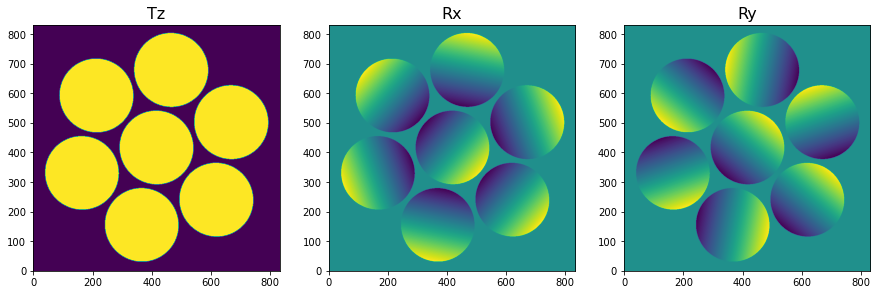

In [8]:
phtemp = np.zeros((nPx, nPx))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches((15,5))

phtemp[zerntool.GMTmask] = np.sum(zerntool.IFmats['M1']['SPP_IFmat'], axis=1)
im1 = ax1.imshow(phtemp, origin='lower')
#clb1 = fig.colorbar(im1, ax=ax1)
ax1.set_title('Tz', fontsize=16)

phtemp[zerntool.GMTmask] = np.sum(zerntool.IFmats['M1']['RxRy_IFmat'][:,0:7], axis=1)
im2 = ax2.imshow(phtemp, origin='lower')
#clb2 = fig.colorbar(im2, ax=ax2)
ax2.set_title('Rx', fontsize=16)

phtemp[zerntool.GMTmask] = np.sum(zerntool.IFmats['M1']['RxRy_IFmat'][:,7:], axis=1)
im3 = ax3.imshow(phtemp, origin='lower')
#clb3 = fig.colorbar(im3, ax=ax3)
ax3.set_title('Ry', fontsize=16);

Text(0.5, 1.0, 'act 200')

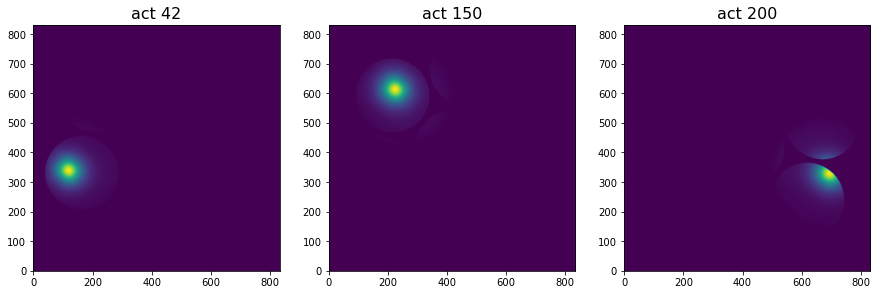

In [9]:
#----- Show three DM poke just for fun.
myacts = [42, 150, 200]
phtemp = np.zeros((nPx, nPx))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches((15,5))

phtemp[zerntool.GMTmask] = zerntool.IFmats['M1']['DM_IFmat'][:,myacts[0]]
im1 = ax1.imshow(phtemp, origin='lower')
#clb1 = fig.colorbar(im1, ax=ax1)
ax1.set_title('act %d'%myacts[0], fontsize=16)

phtemp[zerntool.GMTmask] = zerntool.IFmats['M1']['DM_IFmat'][:,myacts[1]]
im2 = ax2.imshow(phtemp, origin='lower')
#clb2 = fig.colorbar(im2, ax=ax2)
ax2.set_title('act %d'%myacts[1], fontsize=16)

phtemp[zerntool.GMTmask] = zerntool.IFmats['M1']['DM_IFmat'][:,myacts[2]]
im3 = ax3.imshow(phtemp, origin='lower')
#clb3 = fig.colorbar(im3, ax=ax3)
ax3.set_title('act %d'%myacts[2], fontsize=16)

## Projection matrix
Compute the inverse of the merged influence function matrix. This matrix is used to compute Zernike modes as linear combination of WFPT PTT array + DM commands.

In [10]:
dm_valid_acts_file = 'M1_DM_valid_actuators_with_slaving_v1.npz'
zerntool.get_projection_matrix(mirror, dm_valid_acts_file=dm_valid_acts_file)

Restoring valid DM actuators from file: M1_DM_valid_actuators_with_slaving_v1.npz
--> Merged IFmat computed successfully.
--> Projection Matrix computed successfully.


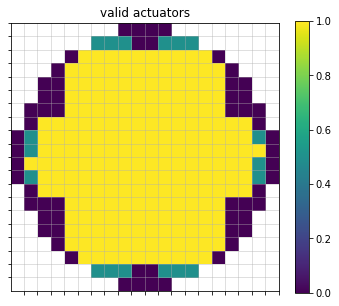

In [11]:
valid_acts = zerntool.IFmats[mirror]['dm_valid_actuators']['valid_acts'].astype('float')
valid_acts[zerntool.IFmats[mirror]['dm_valid_actuators']['act_slaves']] = 0.5
wfpt_visulib.show_dm292(valid_acts, title='valid actuators')

## Segment Zernike fitting
Using both PTT array and DM (simple LS fitting)

In [12]:
%%time
zerntool.get_fitted_zernikes(mirror)

--> Fitted Zernikes computed successfully.
CPU times: user 2min 13s, sys: 316 ms, total: 2min 13s
Wall time: 2min 13s


### Crosstalk Requirements Verification

- **REQ-1090610**: WFPT M1 Low-Order Segment Aberration Cross-Talk: The WFPT M1 low-order segment modes shall have a cross-talk between segments of ≤30% for applied amplitudes ≤1.0 μm RMS wavefront.
- **REQ-109061**: WFPT M2 Low-Order Segment Aberration Cross-Talk: The WFPT M2 low-order segment modes shall have a cross-talk between segments of ≤15% for applied amplitudes ≤1.0 μm RMS wavefront.


See Brian's pptx file: 20200520-DM241-segment-aberrations.pptx for previous error estimations

In [14]:
def p2v(vec):
    return np.max(vec) - np.min(vec)

In [15]:
nzern = zerntool.Zmat.shape[1]
Zdiff = zerntool.Zmat - zerntool.fitZern[mirror]['Zmat']
p2verr2 = np.zeros((nzern, 7))
fiterr2 = np.zeros((nzern, 7))
for segid in range(7):
    for zid in range(nzern):
        p2verr2[zid,segid] = p2v(Zdiff[:,zid,segid]) / p2v(zerntool.Zmat[:,zid,segid])
        fiterr2[zid,segid] = np.std(Zdiff[:,zid,segid]) / np.sqrt(np.sum(zerntool.Zmat[:,zid,segid]**2)/zerntool.npseg[segid])

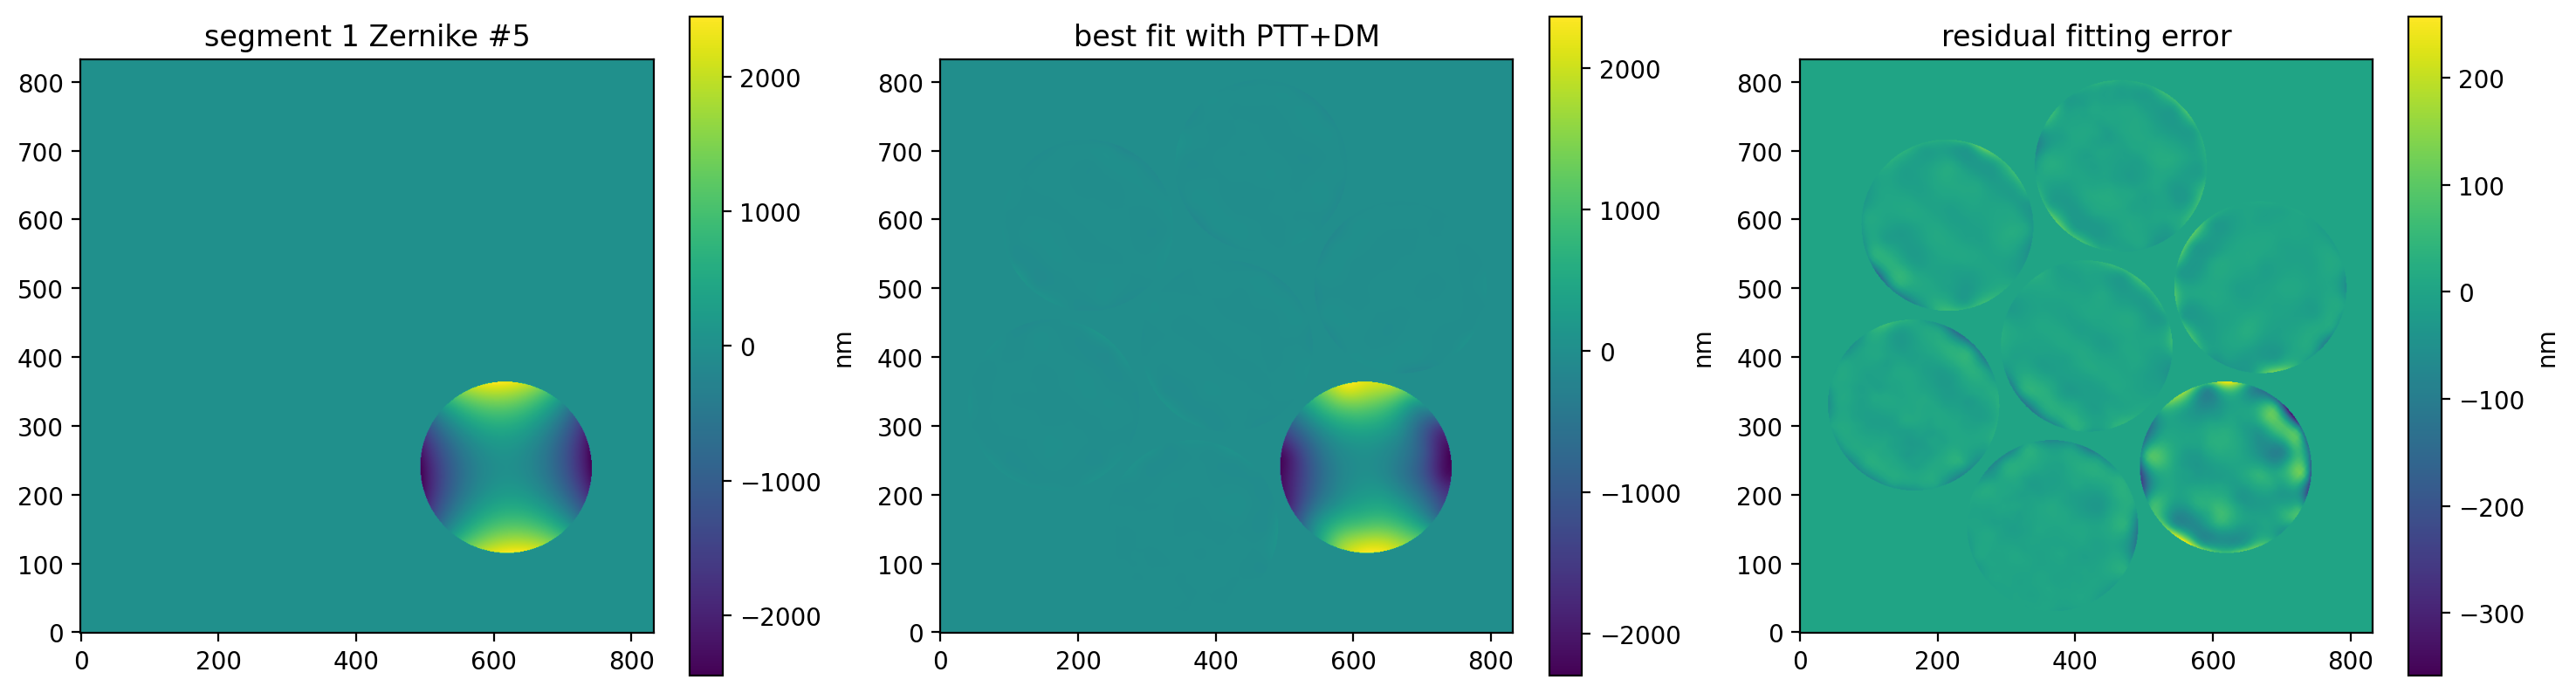

In [16]:
segid = 0
zid = 4
zamp = 1e-6

#-- Theoretical Zernike
Ztheo = np.zeros((nPx,nPx))
Ztheo[zerntool.GMTmask] = zerntool.Zmat[:,zid,segid]

#-- Best-fit Zernike
Zbf = np.zeros((nPx,nPx))
Zbf[zerntool.GMTmask] = zerntool.fitZern[mirror]['Zmat'][:,zid,segid]

#-- Error
Zerr = np.zeros((nPx,nPx))
Zerr[zerntool.GMTmask] = Zdiff[:,zid,segid]

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches((18,5))
fig.dpi=200

im1 = ax1.imshow(Ztheo*zamp*1e9, origin='lower')
clb1 = fig.colorbar(im1, ax=ax1, label='nm')
ax1.set_title('segment %d Zernike #%d'%(segid+1, zid+1))

im2 = ax2.imshow(Zbf*zamp*1e9, origin='lower')
clb2 = fig.colorbar(im2, ax=ax2, label='nm')
ax2.set_title('best fit with PTT+DM');

im3 = ax3.imshow(Zerr*zamp*1e9, origin='lower')
clb2 = fig.colorbar(im3, ax=ax3, label='nm')
ax3.set_title('residual fitting error');

Text(0.5, 1.0, 'fitting using PTT+DM (simple LS)')

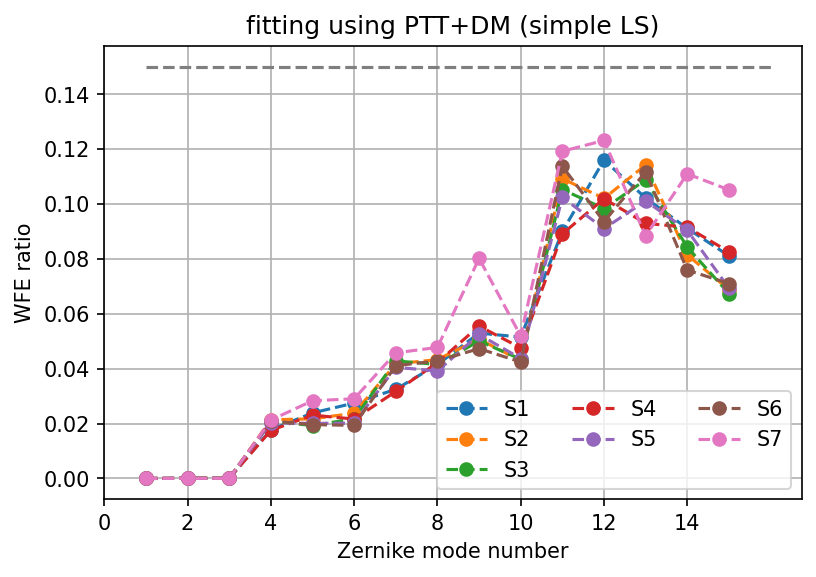

In [38]:
fig, ax = plt.subplots()
fig.dpi=150
ax.plot(np.arange(nzern)+1, fiterr2, 'o--')
ax.plot([1,nzern+1], [0.15,0.15], '--')
ax.legend(['S1','S2','S3','S4','S5','S6','S7'], ncol=3, loc='lower right')
ax.grid()
ax.set_xticks(np.arange(0,nzern,2))
ax.set_xlabel('Zernike mode number')
ax.set_ylabel('WFE ratio')
ax.set_title('fitting using PTT+DM (simple LS)')

Text(0.5, 1.0, 'fitting using PTT+DM (simple LS)')

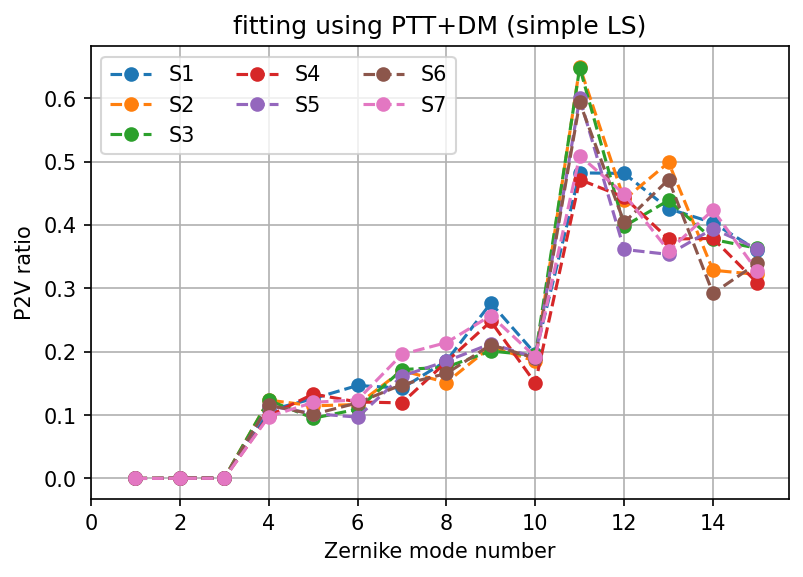

In [42]:
fig, ax = plt.subplots()
fig.dpi=150
ax.plot(np.arange(nzern)+1, p2verr2, 'o--')
ax.legend(['S1','S2','S3','S4','S5','S6','S7'], ncol=3)
ax.grid()
ax.set_xticks(np.arange(0,nzern,2))
ax.set_xlabel('Zernike mode number')
ax.set_ylabel('P2V ratio')
ax.set_title('fitting using PTT+DM (simple LS)')

### Verify Zernike generation by applying commands

array([0.0687665 , 0.06382017, 0.07117642, 0.08446489, 0.07543638,
       0.06655784, 0.95954144], dtype=float32)

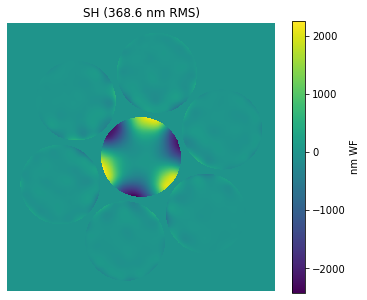

In [19]:

segid = 6
zid = 8
amp = 1e-6
zern_comm = amp * zerntool.fitZern[mirror]['M2C'][:,zid,segid]
pistvec, ttvec, dmvec = np.split(zern_comm, [7, 7+14])

zerntool.wfpt.reset()
state = zerntool.wfpt.state
state[mirror+'_PTT']['segment tip-tilt'][:] = ttvec.reshape((7,2), order='F')
state[mirror+'_PTT']['segment piston'][:] = pistvec
state[mirror+'_DM']['actuators'][:] = dmvec
zerntool.wfpt.update(state)
zerntool.path.propagate(zerntool.src)
zerntool.wfpt.show_wavefront()
zerntool.src.phaseRms(where='segments')*1e6

Commands that generate requested segment Zernike.

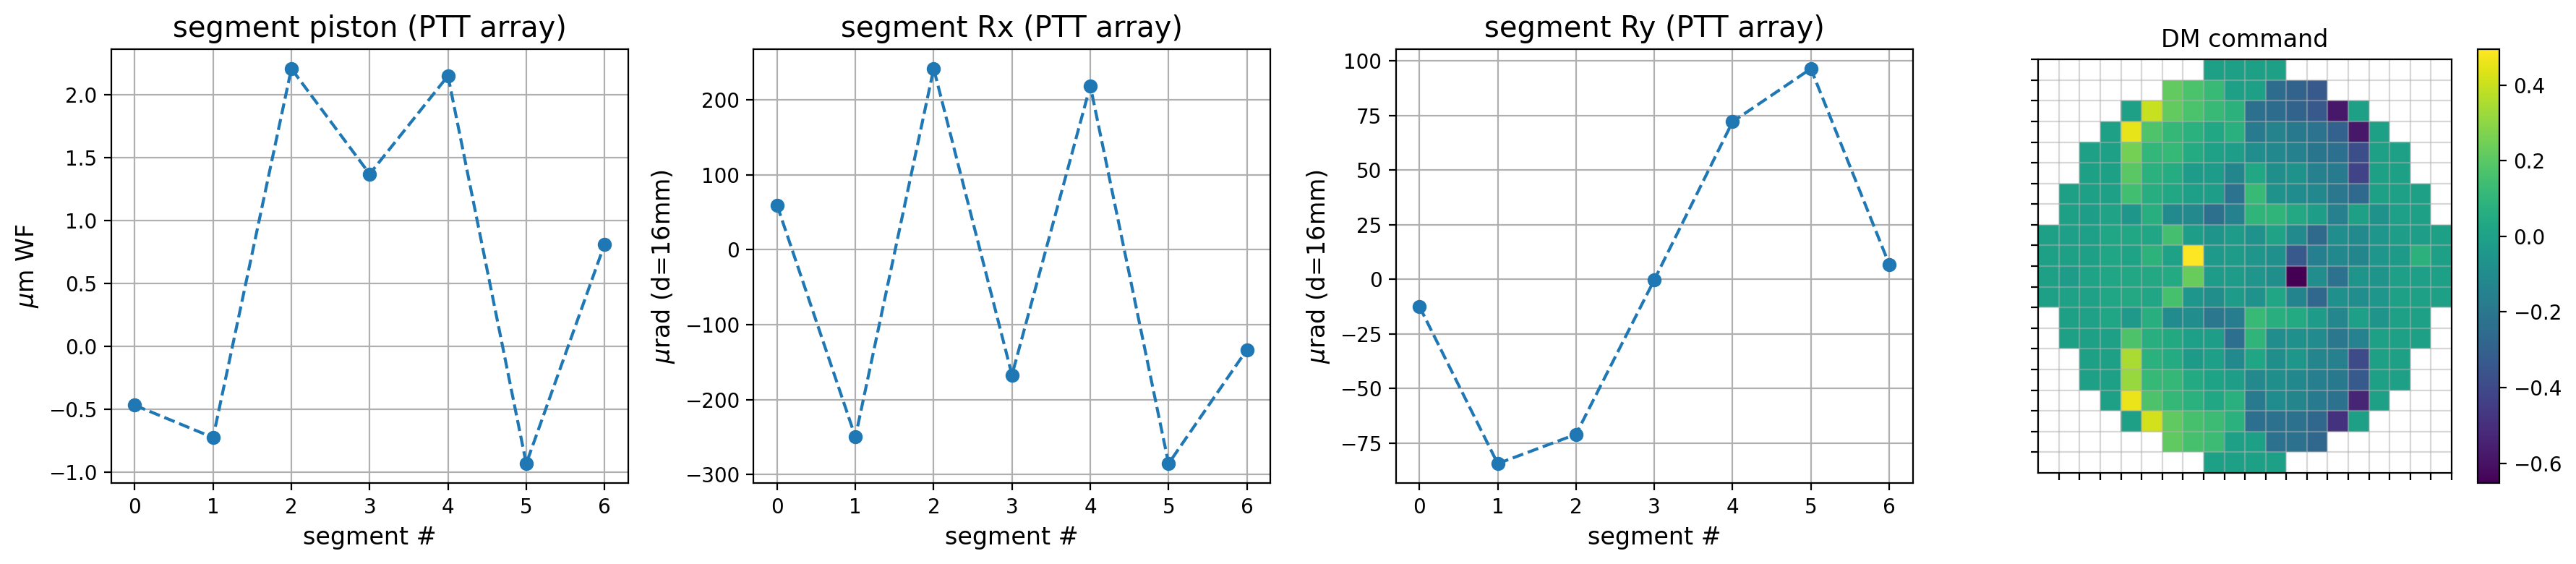

In [20]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)
fig.set_size_inches((18,4))
fig.dpi=200

ax1.plot(pistvec*1e6, 'o--')
ax1.set_xlabel('segment #', fontsize='large')
ax1.set_ylabel('$\mu$m WF', fontsize='large')
ax1.set_title('segment piston (PTT array)', fontsize='x-large')
ax1.grid()

ax2.plot(ttvec[0:7]*1e6, 'o--')
ax2.set_xlabel('segment #', fontsize='large')
ax2.set_ylabel('$\mu$rad (d=16mm)', fontsize='large')
ax2.set_title('segment Rx (PTT array)', fontsize='x-large')
ax2.grid()

ax3.plot(ttvec[7:]*1e6, 'o--')
ax3.set_xlabel('segment #', fontsize='large')
ax3.set_ylabel('$\mu$rad (d=16mm)', fontsize='large')
ax3.set_title('segment Ry (PTT array)', fontsize='x-large')
ax3.grid()

wfpt_visulib.show_dm292(dmvec, fig=fig, ax=ax4)
ax4.set_title('DM command');
fig.tight_layout()

### Stroke Requirements Verification
- **REQ-93714**: WFPT M1 Low-Order Segment Aberrations: The WFPT shall generate Zernike modes Z4-Z10 and Z12-Z15 on each segment in the pupil with a stroke of ≥5 μm P-V wavefront.
- **REQ-93715**: WFPT M2 Low-Order Segment Aberrations: The WFPT shall generate Zernike modes Z4-Z10 and Z12-Z15 on each segment at the M2 conjugate with ≥5 μm P-V wavefront.


Find the maximum Zernike amplitude that can be applied before DM saturation occurs [-1,1].

In [21]:
zamp = np.arange(0,10e-6,100e-9) # large range of amplitudes
namps = len(zamp)
n_samples = 4
maxamp_buffer = np.zeros((2,n_samples)) #keep n_samples values to do linear interpolation
zern_maxamp = np.zeros((nzern,7))
zern_maxp2v = np.zeros((nzern,7))

for segid in range(7):
    for zid in range(nzern):
        for jj in range(namps):
            zern_comm = zamp[jj] * zerntool.fitZern[mirror]['M2C'][:,zid,segid]
            pistvec, ttvec, dmvec = np.split(zern_comm, [7, 7+14])
            dm_maxamp = np.max(np.abs(dmvec))
            maxamp_buffer = np.roll(maxamp_buffer,1, axis=1)
            maxamp_buffer[1,0] = zamp[jj]
            maxamp_buffer[0,0] = dm_maxamp
            if dm_maxamp >= 1:
                zern_maxamp[zid,segid] = np.interp(1.0, np.flip(maxamp_buffer[0,:]), np.flip(maxamp_buffer[1,:]))
                phtemp = zern_maxamp[zid,segid] * zerntool.fitZern[mirror]['Zmat'][:,zid,segid]
                zern_maxp2v[zid,segid] =  p2v(phtemp)
                break

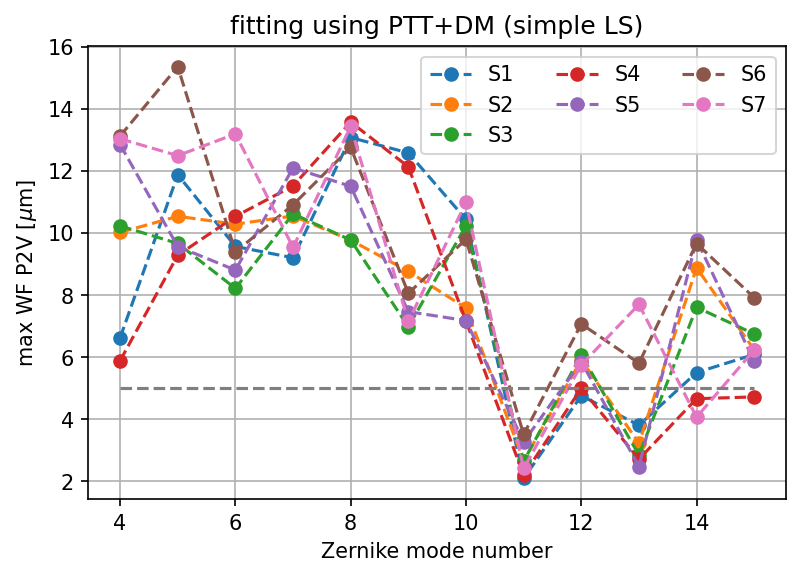

In [22]:
fig, ax = plt.subplots()
fig.dpi=150
ax.plot(np.arange(nzern-3)+4, zern_maxp2v[3:]*1e6, 'o--')
ax.plot([4,15],[5,5], '--')
ax.legend(['S1','S2','S3','S4','S5','S6','S7'], ncol=3)
ax.grid()
ax.set_xticks(np.arange(4,nzern,2))
ax.set_xlabel('Zernike mode number')
ax.set_ylabel('max WF P2V [$\mu$m]')
ax.set_title('fitting using PTT+DM (simple LS)');

Zernike amplitude [um RMS]: 2.252
Measured segment WF RMS [um RMS]: 2.206
Measured WF P2V [um]: 12.170


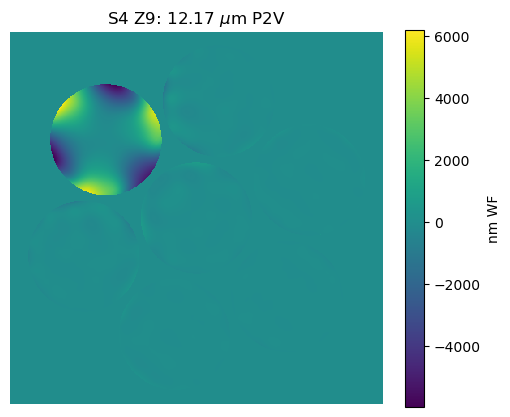

In [39]:
#---- Verify maximum stroke with an actual propagation simulation
zid = 9 -1
segid = 4 -1
myamp = zern_maxamp[zid,segid]
zern_comm = myamp * zerntool.fitZern[mirror]['M2C'][:,zid,segid]
pistvec, ttvec, dmvec = np.split(zern_comm, [7, 7+14])

zerntool.wfpt.reset()
state = zerntool.wfpt.state
state[mirror+'_PTT']['segment tip-tilt'][:] = ttvec.reshape((7,2), order='F')
state[mirror+'_PTT']['segment piston'][:] = pistvec
state[mirror+'_DM']['actuators'][:] = dmvec
zerntool.wfpt.update(state)
zerntool.path.propagate(zerntool.src)
segrms = zerntool.src.phaseRms(where='segments')*1e6
print("Zernike amplitude [um RMS]: %0.3f"%(myamp*1e6))
print("Measured segment WF RMS [um RMS]: %0.3f"%(segrms[segid]))
mode_p2v = p2v(zerntool.wfpt.opd())*1e6
print("Measured WF P2V [um]: %0.3f"%mode_p2v)
zerntool.wfpt.show_wavefront(title='S%d Z%d: %0.2f $\mu$m P2V'%(segid+1,zid+1,mode_p2v))

Commands that generate requested segment Zernike.

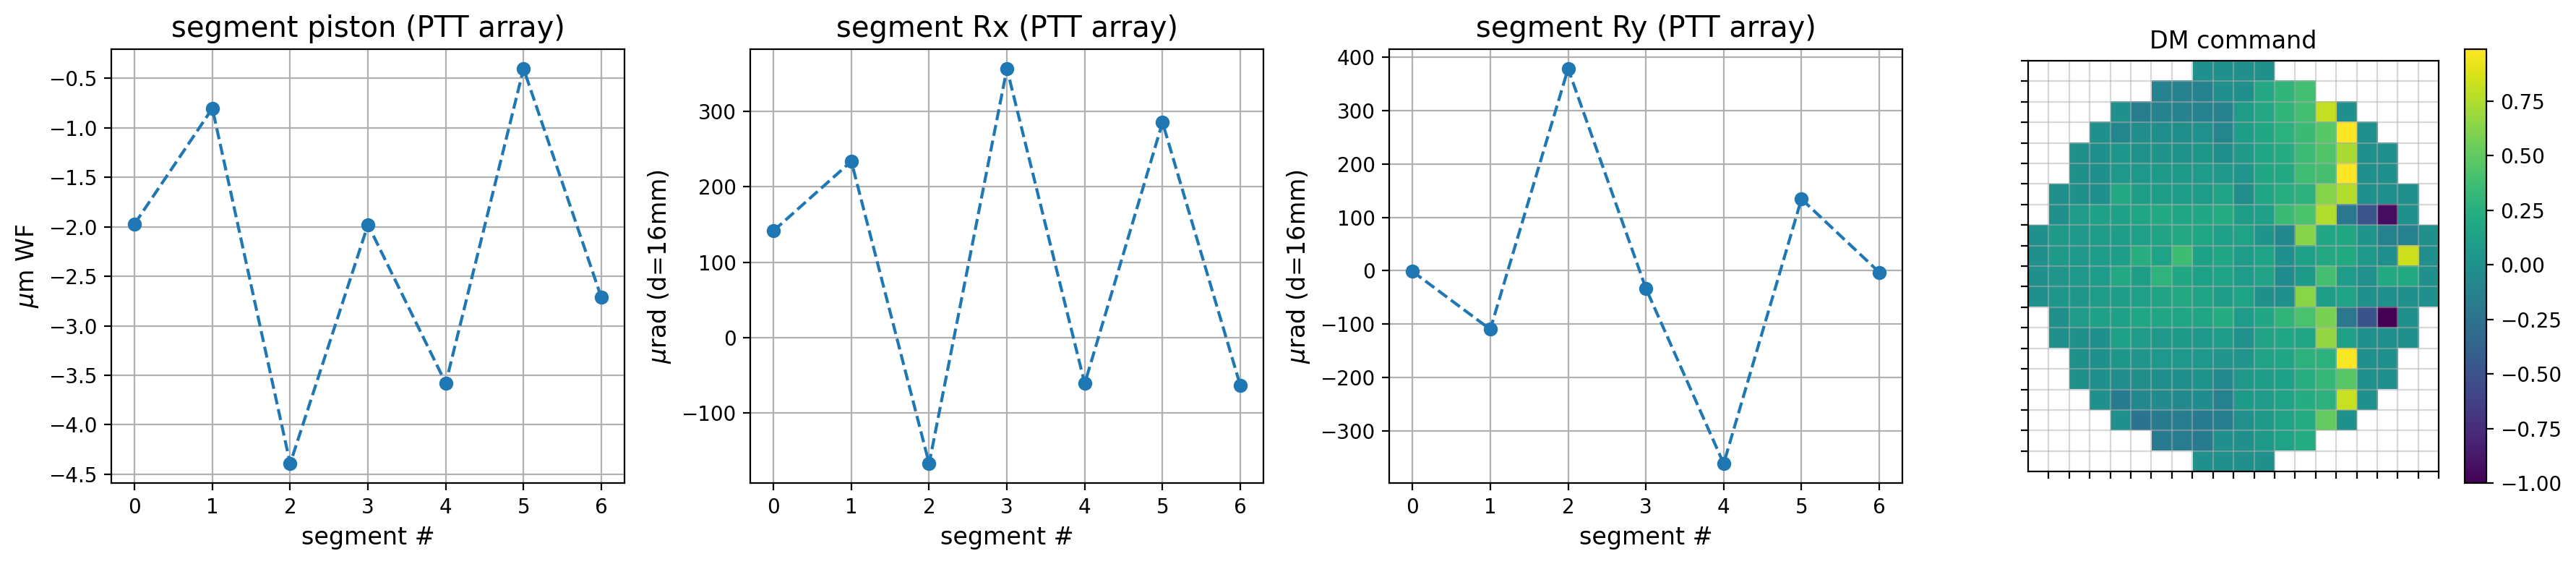

In [41]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)
fig.set_size_inches((18,4))
fig.dpi=200

ax1.plot(pistvec*1e6, 'o--')
ax1.set_xlabel('segment #', fontsize='large')
ax1.set_ylabel('$\mu$m WF', fontsize='large')
ax1.set_title('segment piston (PTT array)', fontsize='x-large')
ax1.grid()

ax2.plot(ttvec[0:7]*1e6, 'o--')
ax2.set_xlabel('segment #', fontsize='large')
ax2.set_ylabel('$\mu$rad (d=16mm)', fontsize='large')
ax2.set_title('segment Rx (PTT array)', fontsize='x-large')
ax2.grid()

ax3.plot(ttvec[7:]*1e6, 'o--')
ax3.set_xlabel('segment #', fontsize='large')
ax3.set_ylabel('$\mu$rad (d=16mm)', fontsize='large')
ax3.set_title('segment Ry (PTT array)', fontsize='x-large')
ax3.grid()

wfpt_visulib.show_dm292(dmvec, fig=fig, ax=ax4)
ax4.set_title('DM command');
fig.tight_layout()